## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

In [3]:
import pandas as pd
import numpy as np
from typing import Union
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from warnings import filterwarnings

filterwarnings('ignore')

In [5]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [6]:
movies = pd.read_csv("ml-1m/movies.dat", sep="::", engine="python",encoding="ISO-8859-1", names=["movie_id", "title", "genres"])

In [7]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [8]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [9]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [10]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [11]:
movies = movies[movies.movie_id.isin(df_train.item_id.unique())]

In [19]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])
movies['movie_id'] = item_le.transform(movies['movie_id'])

In [21]:
movies.set_index("movie_id", inplace=True)

In [23]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

In [25]:
df_train['user_id'].nunique()

5365

### Задание 1. 
**Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате**

In [32]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:

    result = df.pivot(index = 'user_id', columns = 'item_id', values ='rating').fillna(0).to_numpy()

    return result #shape ~ [n_users, n_items]

In [34]:
interactions = df_to_matrix(df_train)

In [36]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    n_u, n_i = df.user_id.nunique(), df.item_id.nunique()
    
    result = coo_array((df.rating, (df.user_id, df.item_id)), 
                       shape=(n_u, n_i), dtype=np.float64)
    
    return result # coo_array

In [38]:
coo_interactions = df_to_coo(df_train)

In [40]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

### Задание 2.1.
**Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо**

In [43]:
from numpy.linalg import svd
from scipy.sparse.linalg import svds

def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    
    if isinstance(interractions, np.ndarray):
        if n_singular_values == -1:  
            U, s, V = svd(interactions)
            S = np.zeros(interactions.shape)
            S[:len(s), :len(s)] = np.diag(s)
            
        else:  
            U, s, V = svd(interractions)
            k = n_singular_values
            U, s, V = U[:, :k], s[:k], V[:k, :]
            S = np.zeros((k, k))
            S[:len(s), :len(s)] = np.diag(s)
            
    else:  
        k = min(interractions.shape) - 1 if n_singular_values == -1 else n_singular_values
        U, s, V = svds(interractions, k=k)
        S = np.zeros((k, k))
        S[:len(s), :len(s)] = np.diag(s)

    return U, S, V

In [45]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [46]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

### Задание 2.2.
**Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал**

In [48]:
def top_k_recs_one(user_row, preds_row, k=20):
    df = pd.DataFrame(data=zip(user_row, preds_row), columns=['init', 'preds'])
    df = df.sort_values(by='init', ascending=False)
    df['preds'] = df['preds'].astype('float32')
    return df.sort_values(by='preds', ascending=False)[df.init == 0].head(k).index.values

In [49]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал
    k = top_k
    
    U, S, V = make_svd(interractions, n_singular_values)
    preds = U @ S @ V
    
    if isinstance(interractions, coo_array):
        interractions = interractions.toarray()
    
    
    recommendations = np.array([top_k_recs_one(interractions[i,:], preds[i, :], top_k) for i in range(interractions.shape[0])])

    return recommendations #shape ~ [n_users, top_k]

In [50]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

### Задание 2.3. 
**Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)**

In [52]:
def ndcg_metric(gt_items, predicted):
    
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)

In [53]:
def plot_graphs(interactions, df_test = df_test, top_k=100):

    ndcg_scores = []
    times = []
    n_singular_values_list =[1, 10, 50, 100, 200, 500, 750, 1000]
    
    gt_dict = df_test.groupby("user_id")["item_id"].apply(set).to_dict()
    
    for n_singular_values in n_singular_values_list:
        start_time = time()

        recs = make_svd_recommendations(interractions = interactions, n_singular_values = n_singular_values, top_k = top_k)
        ndcg_scores_list = []
        for user_id in gt_dict.keys():
            if user_id in gt_dict:
                gt_items = gt_dict[user_id]  # Истинные item_id
                ndcg = ndcg_metric(gt_items, recs[user_id, :])  # Вычисляем NDCG
                ndcg_scores_list.append(ndcg)
        
        avg_ndcg = np.mean(ndcg_scores_list)
        ndcg_scores.append(avg_ndcg)
        
        # Засекаем время выполнения
        elapsed_time = time() - start_time
        times.append(elapsed_time)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    sns.lineplot(x = n_singular_values_list, y = ndcg_scores, ax=axes[0], color = 'powderblue')
    sns.lineplot(x = n_singular_values_list, y = times, ax=axes[1], color = 'crimson')
    sns.scatterplot(x=n_singular_values_list, y=ndcg_scores, ax=axes[0], color='powderblue', s=25, edgecolor="gray")
    sns.scatterplot(x=n_singular_values_list, y=times, ax=axes[1], color='crimson', s=25, edgecolor="gray")
    axes[0].set_xlabel("Amount of singular values")
    axes[1].set_xlabel("Amount of singular values")
    axes[0].set_ylabel("Mean NDCG values")
    axes[1].set_ylabel("Amount of time for execution in seconds")
    plt.show()


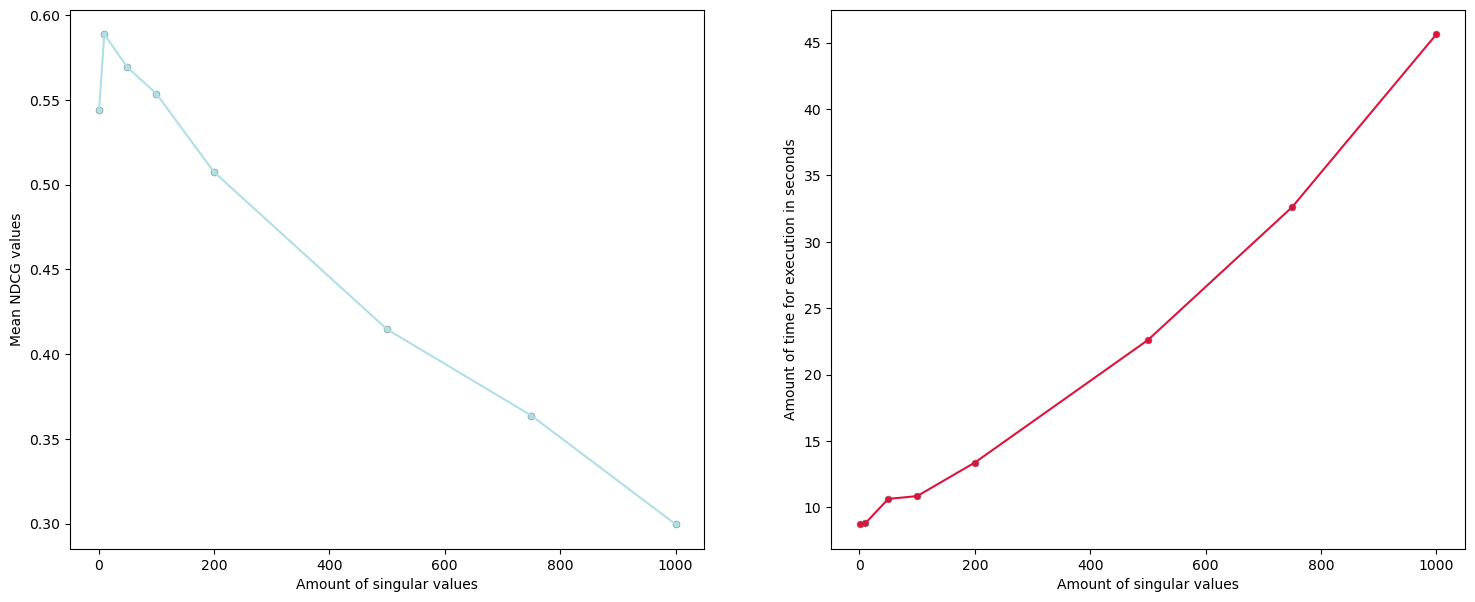

In [54]:
plot_graphs(coo_interactions)

### Задание 3.1.
**Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.**

In [56]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    users_items = csr_matrix(interractions)
    als = AlternatingLeastSquares(factors = n_factors,
                                  alpha = alpha,
                                  regularization = regularization)
    als.fit(users_items)
    users_ids = np.arange(0, interractions.shape[0])
    recs = als.recommend(users_ids, users_items, N=top_k, filter_already_liked_items=True)
    recommendations = recs[0]
    values = recs[1]
    


    return recommendations #shape ~ [n_users, top_k]

In [57]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [58]:
def get_mean_ndcg(recs, df):
    ndcg_scores_list = []
    gt_dict = df.groupby("user_id")["item_id"].apply(set).to_dict()
    for user_id in gt_dict.keys():
        if user_id in gt_dict:
            gt_items = gt_dict[user_id]
            ndcg = ndcg_metric(gt_items, recs[user_id, :])
            ndcg_scores_list.append(ndcg)

    return np.mean(ndcg_scores_list)

In [59]:
get_mean_ndcg(recs, df_test)

0.5501194953120158

In [61]:
def iALS_objective(trial, interractions, df_test):

    n_factors = trial.suggest_int('n_factors', 5, 20)  # Регуляризация
    alpha = trial.suggest_float('alpha', 1.0, 5.0)
    regularization = trial.suggest_float('regularization', 0.001, 0.1)

    recs = make_als_recommendations(interractions = interractions,
                                   n_factors = n_factors,
                                   alpha = alpha,
                                   regularization = regularization)

    
    return get_mean_ndcg(recs, df_test)

def optimize_als(interractions, df_test, n_trials=30):

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: iALS_objective(trial, interractions, df_test), n_trials=n_trials)

    print(f'Лучшие гиперпараметры: {study.best_params}')
    return study.best_params

In [63]:
#best_params = optimize_als(coo_interactions, df_test, n_trials=50)
best_params = {'n_factors': 8, 'alpha': 2.6903242100469362, 'regularization': 0.007922643264765536}

In [65]:
recs = make_als_recommendations(**best_params, interractions = coo_interactions)
recs2 = make_svd_recommendations(interactions, 10, 100)

print(f'NDCG for SVD: {get_mean_ndcg(recs2, df_test)}')
print(f'NDCG for iALS: {get_mean_ndcg(recs, df_test)}')

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG for SVD: 0.588782057248703
NDCG for iALS: 0.5936122170670675


### Задание 3.2.
**Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием**

In [67]:
csr_interactions = csr_matrix(coo_interactions)

als = AlternatingLeastSquares(factors=8, regularization=0.0079, alpha=2.690)
als.fit(csr_interactions)

for user_id in np.random.randint(0, 5364, 5):
    print(f'\nОбъяснение рекомендаций для пользователя {user_id}')

    recommended_items, _ = als.recommend(user_id, csr_interactions[user_id], N=2)
    
    for item_id in recommended_items:
        explanation = als.explain(user_id, csr_interactions, item_id)
        
        contrib_items = explanation[1] 
        
        print(f'\n Фильм: {movies.loc[item_id, 'title']} (ID: {item_id})')
        print('Этот фильм был рекомендован из-за влияния следующих фильмов:')

        for contrib_id, weight in contrib_items:
            print(f" - {movies.loc[contrib_id, 'title']} (вес: {weight:.4f})")

  0%|          | 0/15 [00:00<?, ?it/s]


Объяснение рекомендаций для пользователя 1157

 Фильм: American Beauty (1999) (ID: 2168)
Этот фильм был рекомендован из-за влияния следующих фильмов:
 - Silence of the Lambs, The (1991) (вес: 0.0610)
 - Pulp Fiction (1994) (вес: 0.0588)
 - Babe (1995) (вес: 0.0569)
 - Fargo (1996) (вес: 0.0569)
 - Being John Malkovich (1999) (вес: 0.0556)
 - Usual Suspects, The (1995) (вес: 0.0435)
 - Princess Bride, The (1987) (вес: 0.0419)
 - L.A. Confidential (1997) (вес: 0.0418)
 - Sixth Sense, The (1999) (вес: 0.0364)
 - 2001: A Space Odyssey (1968) (вес: 0.0309)

 Фильм: Schindler's List (1993) (ID: 449)
Этот фильм был рекомендован из-за влияния следующих фильмов:
 - Pulp Fiction (1994) (вес: 0.0555)
 - Silence of the Lambs, The (1991) (вес: 0.0552)
 - Fargo (1996) (вес: 0.0512)
 - Babe (1995) (вес: 0.0466)
 - Usual Suspects, The (1995) (вес: 0.0419)
 - L.A. Confidential (1997) (вес: 0.0384)
 - Being John Malkovich (1999) (вес: 0.0339)
 - Princess Bride, The (1987) (вес: 0.0321)
 - 2001: A Space

### Задание 4.
**До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом**

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [69]:
def df_to_matrix(df: pd.DataFrame, col: str = 'rating') -> np.ndarray:

    result = df.pivot(index = 'user_id', columns = 'item_id', values ='rating').fillna(0).to_numpy()

    return result #shape ~ [n_users, n_items]

In [70]:
def df_to_coo(df: pd.DataFrame, col: str = 'rating') -> coo_array:

    n_u, n_i = df.user_id.nunique(), df.item_id.nunique()
    
    result = coo_array((df[col], (df.user_id, df.item_id)), 
                       shape=(n_u, n_i), dtype=np.float64)
    
    return result # coo_array

**1.Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)**

In [72]:
df_train['bin_var1'] = np.where(df_train.rating > 0, 1, 0)
coo_inter_1 = df_to_coo(df_train, 'bin_var1')

In [76]:
svd_recs = make_svd_recommendations(coo_inter_1, n_singular_values=10)
als_recs = make_als_recommendations(**best_params, interractions = coo_inter_1)

print(f'NDCG for SVD: {get_mean_ndcg(svd_recs, df_test)}')
print(f'NDCG for iALS: {get_mean_ndcg(als_recs, df_test)}')

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG for SVD: 0.5742313395172395
NDCG for iALS: 0.5846846187704131


**2.Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0**

In [78]:
df_train['bin_var2'] = np.where(df_train.rating >= 4, 1, 0)
coo_inter_2 = df_to_coo(df_train, 'bin_var2')

In [79]:
svd_recs = make_svd_recommendations(coo_inter_2, n_singular_values=10)
als_recs = make_als_recommendations(**best_params, interractions = coo_inter_2)

print(f'NDCG for SVD: {get_mean_ndcg(svd_recs, df_test)}')
print(f'NDCG for iALS: {get_mean_ndcg(als_recs, df_test)}')

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG for SVD: 0.5607541689875705
NDCG for iALS: 0.5928668417453248


**3.Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1**

In [81]:
df_train['bin_var3'] = np.where(df_train.rating >= 4, 1, -1)
coo_inter_3 = df_to_coo(df_train, 'bin_var3')

In [82]:
svd_recs = make_svd_recommendations(coo_inter_3, n_singular_values=10)
als_recs = make_als_recommendations(**best_params, interractions = coo_inter_3)

print(f'NDCG for SVD: {get_mean_ndcg(svd_recs, df_test)}')
print(f'NDCG for iALS: {get_mean_ndcg(als_recs, df_test)}')

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG for SVD: 0.5654355014883644
NDCG for iALS: 0.589999052720473


**4.Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы**

In [84]:
df_train["bin_var4"] = np.where(df_train.rating >= 4, 1, -1)
max_date = df_train["datetime"].max()
df_train["days_diff"] = (max_date - df_train["datetime"]).dt.days
lambda_decay = 0.98
df_train["time_weight"] = lambda_decay ** (df_train["days_diff"] / 30)
df_train["bin_var4"] = df_train["bin_var4"] * df_train["time_weight"]

In [85]:
coo_inter_4 = df_to_coo(df_train, 'bin_var4')

In [86]:
svd_recs = make_svd_recommendations(coo_inter_4, n_singular_values=10)
als_recs = make_als_recommendations(**best_params, interractions = coo_inter_4)

print(f'NDCG for SVD: {get_mean_ndcg(svd_recs, df_test)}')
print(f'NDCG for iALS: {get_mean_ndcg(als_recs, df_test)}')

  0%|          | 0/15 [00:00<?, ?it/s]

NDCG for SVD: 0.5666241425606038
NDCG for iALS: 0.5924255348970834


### Задание 5.
**iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit**

In [88]:
def linear_weight(R, alpha=40.0):
    
    R = R.copy().tocsr()
    R.data = 1.0 + alpha * R.data
    return R

class iALS:
    def __init__(
        self,
        n_factors=100,
        alpha=1.0,
        reg_coef=0.01,
        n_iterations=10,
        random_state=42
    ):

        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.n_iterations = n_iterations
        self.random_state = random_state

        self.user_factors = None
        self.item_factors = None
        self.user_items = None  # [u] -> array(indices of items)
        self.user_cminus1 = None # [u] -> array((C[u,i]-1) values)
        self.item_users = None  # [i] -> array(indices of users)
        self.item_cminus1 = None # [i] -> array((C[u,i]-1) for those users)

    def fit(self, interactions: np.ndarray, n_iterations: int = None):
        
        if not isinstance(interactions, csr_matrix):
            interactions = csr_matrix(interactions)
        if n_iterations is not None:
            self.n_iterations = n_iterations

        rng = np.random.default_rng(self.random_state)

        n_users, n_items = interactions.shape

        C = linear_weight(interactions, alpha=self.alpha)  # (1 + alpha * R)
        p = interactions.copy()
        p.data = np.where(p.data > 0, 1.0, 0.0)  # binarized prefs

        scale = 0.01
        self.user_factors = rng.normal(0, scale, size=(n_users, self.n_factors))
        self.item_factors = rng.normal(0, scale, size=(n_items, self.n_factors))

        self.user_items = []
        self.user_cminus1 = []
        for u in range(n_users):
            row_start = C.indptr[u]
            row_end = C.indptr[u+1]
            c_items = C.indices[row_start:row_end]    
            c_vals = C.data[row_start:row_end]          
            cminus1 = c_vals - 1.0
            nonzero_mask = (cminus1 != 0)
            self.user_items.append(c_items[nonzero_mask])
            self.user_cminus1.append(cminus1[nonzero_mask])

        self.item_users = [[] for _ in range(n_items)]
        self.item_cminus1 = [[] for _ in range(n_items)]
        for u in range(n_users):
            Iu = self.user_items[u]
            Cu_vals = self.user_cminus1[u]
            for i_idx, item_id in enumerate(Iu):
                val_cminus1 = Cu_vals[i_idx]
                self.item_users[item_id].append(u)
                self.item_cminus1[item_id].append(val_cminus1)

        for i in range(n_items):
            self.item_users[i] = np.array(self.item_users[i], dtype=int)
            self.item_cminus1[i] = np.array(self.item_cminus1[i], dtype=float)

        regI = self.reg_coef * np.eye(self.n_factors)

        for _ in range(self.n_iterations):
            Y = self.item_factors
            YTY = Y.T @ Y  # (f x f)

            for u in range(n_users):
                Iu = self.user_items[u]
                if len(Iu) == 0:
                    self.user_factors[u] = 0
                    continue

                c_vals = self.user_cminus1[u]   # (C[u,i]-1)
                sum_yi = np.zeros(self.n_factors)
                sum_yi_yiT = np.zeros((self.n_factors, self.n_factors))

                for i, c_minus_1 in zip(Iu, c_vals):
                    y_i = Y[i]
                    sum_yi += c_minus_1 * y_i
                    sum_yi_yiT += c_minus_1 * np.outer(y_i, y_i)

                A_u = YTY + sum_yi_yiT + regI
                b_u = sum_yi
                self.user_factors[u] = np.linalg.solve(A_u, b_u)

            X = self.user_factors
            XTX = X.T @ X

            for i in range(n_items):
                Ui = self.item_users[i]
                if len(Ui) == 0:
                    self.item_factors[i] = 0
                    continue

                c_vals = self.item_cminus1[i]
                sum_xu = np.zeros(self.n_factors)
                sum_xu_xuT = np.zeros((self.n_factors, self.n_factors))

                for (u, c_minus_1) in zip(Ui, c_vals):
                    x_u = X[u]
                    sum_xu += c_minus_1 * x_u
                    sum_xu_xuT += c_minus_1 * np.outer(x_u, x_u)

                A_i = XTX + sum_xu_xuT + regI
                b_i = sum_xu
                self.item_factors[i] = np.linalg.solve(A_i, b_i)

    def predict(self, top_k=100):

        X = self.user_factors
        Y = self.item_factors
        scores = X @ Y.T

        n_users, n_items = scores.shape
        for u in range(n_users):
            Iu = self.user_items[u]
            scores[u, Iu] = -np.inf
            
        top_items = np.argsort(-scores, axis=1)[:, :top_k]
        return top_items

In [89]:
new_params = {'n_factors': 8, 'alpha': 2.6903242100469362, 'reg_coef': 0.007922643264765536}

In [90]:
my_als = iALS(**new_params)
my_als.fit(csr_matrix(coo_interactions))
my_als_recs = my_als.predict()

In [91]:
get_mean_ndcg(my_als_recs, df_test)

0.5919583935074193